# Importing libraries

### Importing all libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import cv2
import json

from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer

# from langid.langid import LanguageIdentifier, model
# from langid.langid import set_languages
import time

from nltk.stem import WordNetLemmatizer

In [2]:
## define date & time to print-out files

from datetime import date, datetime

def date_time():
    today = date.today()
    now = datetime.now() 

    return today.strftime("_%Y%m%d") +'_'+ now.strftime("%H%M")


In [3]:
my_seed = 123

# Defining functions

### Feature engineering: title_descr
[ ] does the function need to have a return df?

In [5]:
def concatenate_variables(df, col1, col2, nans_to, separator, concat_col_name, to_drop = None):
    '''
    Replace NaNs in col1 and col2 with string nans_to
    Concatenate col1 and col2 using a separator string separator
    Drop columns if specified by to drop (list of columns)
    save in a new variable named by concat_col_name
    '''
    
    ## Replace NaN's in description with empty string
    df[col1] = df[col1].fillna(nans_to)
    df[col2] = df[col2].fillna(nans_to)

    ## Concatenate col1 with col2
    df[concat_col_name] = df[col1] + separator + df[col2]
    
    ## drop columns
    if to_drop is not None:
        for col in to_drop:
            df.drop(col, axis = 1, inplace = True)


### HTML parsing 

In [6]:
def html_parsing(df, col_to_parse, verbose = False):
    '''
    HTML parse and lower case text content in col_to_parse
    '''
    t0 = time.time()

    df[col_to_parse] = [BeautifulSoup(text).get_text().lower() for text in df.loc[:,col_to_parse]]

    t1 = time.time()
    
    if verbose: 
        print(f"Column '{col_to_parse}' has been successfully HTML parsed")
        print("HTML parsing takes %0.2f seconds" %(t1-t0))

### Feature engineering: Tokenization & Lemmatization

In [7]:

def get_lemmatized_tokens(df, col_to_tokenize, tokenizer, tokenized_col, lemmatizer, uniques = False, verbose = True):
    '''
    For each row creates a list of tokens obtained from 'col_to_tokenize' column by tokenizing the text.
    Then lemmatize each word in the list, for each row.
    If unique = True, remove duplicated from each list of lemmas using set(). Keep the order of the words in list.
    Store list of lemmas in a new variable 'tokenized_col'
    '''    
    
    t0 = time.time()
    
    all_token_list = [tokenizer.tokenize(text) for text in df.loc[:,col_to_tokenize]]
    all_lemmatized_list = [ [lemmatizer.lemmatize(t) for t in token_list] for token_list in all_token_list ]

    if uniques :    
        df[tokenized_col] = [sorted( set(lemma_list), key=lemma_list.index ) for lemma_list in all_lemmatized_list ]
    else:    
        #df[tokenized_col] = [tokenizer.tokenize(text) for text in df.loc[:,col_to_tokenize]]
        df[tokenized_col] = all_lemmatized_list

    t1 = time.time()
    
    if verbose:
        print(f"Column '{col_to_tokenize}' has been successfully tokenized")
        print("Tokenization + Lemmatization takes %0.2f seconds" %(t1-t0))
    

### Get Language

In [8]:
def get_language(df, text_col, correct = False, verbose = False):
    
    ## Main language identfication
    ## instantiate identifier to get probabilities
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    
    ## identify language
    time_0 = time.time()

    languages_probas = [identifier.classify(text) for text in df[text_col]]
    
    time_1 = time.time()
        
    if correct:
        ## restricted identifier
        identifier_2 = LanguageIdentifier.from_modelstring(model, norm_probs=True)
        identifier_2.set_languages(langs=['fr','en'])
        
        for i in range(len(languages_probas)):    
            if languages_probas[i][1] < 0.9999:
                languages_probas[i] = identifier_2.classify(df.loc[i,'title_descr'])
                
    time_2 = time.time()
    
    if verbose:
        print("Main language detection takes %0.2f minutes" %((time_1 - time_0)/60) )
        if correct:
            print("Language detection correction takes %0.2f seconds" %(time_2 - time_1) )

    
    language_dict = {'language' : list(np.array(languages_probas)[:,0]),
            'lan_prob' : [float(p) for p in np.array(languages_probas)[:,1]]}
    
    df_languages = pd.DataFrame(language_dict)
    
    return df_languages
    

In [9]:

# def detect_language(df, text_col, correct = False, verbose = False):
    
#     ## Main language identfication
#     ## instantiate identifier to get probabilities
#     identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    
#     ## identify language
#     time_0 = time.time()

#     df[['language', 'lang_prob']] = [identifier.classify(text) for text in df[text_col]]

    
#     time_1 = time.time()
        
#     if correct:
#         ## restricted identifier
#         identifier_2 = LanguageIdentifier.from_modelstring(model, norm_probs=True)
#         identifier_2.set_languages(langs=['fr','en'])
        
#         for i in range(len(df)):    
#             if df.loc[i,'lang_prob'] < 0.9999:
#                 df.loc[i,['language', 'lang_prob']] = identifier_2.classify(df.loc[i,'title_descr'])
                
#     time_2 = time.time()
    
#     if verbose:
#         print("Main language detection takes %0.2f minutes" %((time_1 - time_0)/60) )
#         if correct:
#             print("Language detection correction takes %0.2f seconds" %(time_2 - time_1) )

    

### Remove stop words from tokens

In function **import_stop_words**:  
- [x] Inlude other languages (if included in spacy)  

In function **remove_stop_words**:  
  > Option-1: Using list comprehension takes 76 seconds for the whole dataframe. DO NOT USE  
  > Option-2: Using a for loop to iterate the dataframe takes 39 seconds for the whole dataframe. 

- [x] Should we use set(tokens) at the end ? to get unique tokens ?
    > Lemmatized tokens are already uniques

In [10]:
def import_stop_words(language):
    '''
    Import list of stop words from the indicated language.
    If language is not in the list of the top 4 languages, use FR+EN by default.
    '''
    
    # top 4 languages in dataset
    available = ['fr', 'en', 'de', 'it']
    
    if language == 'fr':
        from spacy.lang.fr.stop_words import STOP_WORDS as stop_fr
        return list(stop_fr)
        
    elif language == 'en':
        from spacy.lang.en.stop_words import STOP_WORDS as stop_en
        return list(stop_en)

    elif language == 'de':
        from spacy.lang.de.stop_words import STOP_WORDS as stop_de
        return list(stop_de)

    elif language == 'it':
        from spacy.lang.it.stop_words import STOP_WORDS as stop_it
        return list(stop_it)

    else:
        from spacy.lang.fr.stop_words import STOP_WORDS as stop_fr
        from spacy.lang.en.stop_words import STOP_WORDS as stop_en
        return list(stop_fr) + list(stop_en)
    

In [11]:
def remove_stop_words(df, col_to_clean, col_result, col_language, verbose = False):
    '''
    Remove the stop words from each token list in df[col_to_clean] according to the datected language df['language']
    Store the cleaned token list in a new variable df[col_result]
    If col_result result does not exist in dataframe, intialize with empty strings (object dtype)
    '''
    ## Option - 1: list comprehension 
#     t0 = time.time()
#     new_name = col_result + '_O1'
#     df[new_name] = [ [token for token in token_list if token not in import_stop_words(language)] for token_list, language in zip(df.tokens,df.language)]
#     t1 = time.time()


    ## Option - 2: iterate over the dataframe
    t2 = time.time()
    
    new_name = col_result #+ '_O2'
    if new_name not in df.columns:
        df[new_name] = ''  # initilize col as 'object' type
    
    for i, token_list, language in zip(df.index, df[col_to_clean], df[col_language]):
    
        stop_words = import_stop_words(language)        
        df.at[i, new_name] = [token for token in token_list if token not in stop_words]
    
    t3 = time.time()
        
    if verbose:
        #print("time taken with comprehension list %0.f seconds" %(t1-t0))
        print("time taken with for loop list %0.f seconds" %(t3-t2))

### Get token length

In [12]:
def get_token_length(df, col_with_tokens, col_with_length, verbose = False):
    '''
    Creates a new variable measuring the number of tokens in column col_with_tokens
    '''
    t0 = time.time()
    
    df[col_with_length] = [len(token_list) for token_list in df[col_with_tokens] ]
    
    t1 = time.time()
    
    if verbose:
        print("token count takes %0.2f seconds" %(t1-t0))

# Data Processing

### importing all data
[ ] Do we merge df_X or df_y or not ?  
[ ] Drop column 'target' in product_class if problematic.  

In [4]:
## features and target
df_X = pd.read_csv('./datasets/X_train_update.csv', index_col = 0)
df_y = pd.read_csv('./datasets/Y_train_CVw08PX.csv', index_col = 0)

## merge feature and target ? ---> it maybe better for preprocessing, then separate for model training
df = pd.concat([df_y,df_X], axis = 1)

## class labels
product_class = pd.read_csv('./datasets/product_class.csv', sep = ';')


In [9]:
print(type(df_X))
display(df_X.head())

print(type(df_y))
display(df_y.head())

<class 'pandas.core.frame.DataFrame'>


,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


<class 'numpy.ndarray'>


,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


### Rename variables

In [13]:
## Rename th# Importing data and librariese variable 'designation' by 'title' which is more convenient
df.rename({'designation':'title'}, axis = 1, inplace = True)
df.head()

,prdtypecode,title,description,productid,imageid
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


### Feature engineering: title_descr

In [14]:
concatenate_variables(df, 'title', 'description', nans_to = '', separator ='\n', concat_col_name = 'title_descr', \
                      to_drop = None)
df.head()

,prdtypecode,title,description,productid,imageid,title_descr
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,La Guerre Des Tuques\nLuc a des id&eacute;es d...


**Drop redundant variables: Title & Description**

In [15]:
df.drop(['title','description'], axis = 1, inplace = True)

df.head()

,prdtypecode,productid,imageid,title_descr
0,10,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,2280,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,278535884,1077757786,La Guerre Des Tuques\nLuc a des id&eacute;es d...


### HTML parse & lower case

In [16]:
html_parsing(df, 'title_descr', verbose = True)

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Column 'title_descr' has been successfully HTML parsed
HTML parsing takes 20.54 seconds


In [17]:
df.head()

,prdtypecode,productid,imageid,title_descr
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...


### Tokenize & Lemmatize text
* Tokenize title_descr
* Lematize token lists
* if uniques = True, get the unique lematized tokens (no duplicates). Keeps the order.

- [x] I can directly use a tokenizer that keeps only word of more than 2 characters : tokenizer = RegexpTokenizer(r"\w{3,}')

In [18]:
tokenizer = RegexpTokenizer(r'\w{3,}')
lemmatizer = WordNetLemmatizer()

get_lemmatized_tokens(df, 'title_descr', tokenizer, 'lemma_tokens', lemmatizer, uniques = True)

Column 'title_descr' has been successfully tokenized
Tokenization + Lemmatization takes 28.26 seconds


In [19]:
df.head()

,prdtypecode,productid,imageid,title_descr,lemma_tokens
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei..."
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, de, art, 133, 2001, son, marche, sal..."
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni..."
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma..."
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, de, tuques, luc, idées, grandeur, veu..."


### Feature engineering: get language
* Language detection takes about 5 mins.  DO NOT RE DO IT IF NOT NEEDED.


In [58]:

language_df = get_language(df, 'title_descr', correct = True, verbose = True)


NameError: name 'LanguageIdentifier' is not defined

**Save detected languages**

In [ ]:
write = False

if write:    
    filename = 'df_languages_probas' + date_time() + '.csv'
    
    language_df.to_csv(filename, header=True, index=False)
    print(filename)

**Load previously detected languages**

In [20]:
read = True
if read:
    filename = 'df_languages_probas_20230731' + '.csv'
    
    df_languages = pd.read_csv(filename)
    display(df_languages.head())

,language,lan_prob
0,de,1.0
1,fr,1.0
2,fr,1.0
3,fr,1.0
4,fr,1.0


In [21]:
## concatenate to main dataframe
df = pd.concat([df, df_languages], axis = 1)
df.head()

,prdtypecode,productid,imageid,title_descr,lemma_tokens,language,lan_prob
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei...",de,1.0
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, de, art, 133, 2001, son, marche, sal...",fr,1.0
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni...",fr,1.0
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma...",fr,1.0
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, de, tuques, luc, idées, grandeur, veu...",fr,1.0


**Drop language probas if not needed**

In [22]:
df.drop('lan_prob', axis = 1, inplace = True)
df.head()

,prdtypecode,productid,imageid,title_descr,lemma_tokens,language
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei...",de
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, de, art, 133, 2001, son, marche, sal...",fr
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni...",fr
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma...",fr
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, de, tuques, luc, idées, grandeur, veu...",fr


In [88]:
## quick verification:
print(df['language'].unique())
print(df['language'].unique().shape)

['de' 'fr' 'en' 'br' 'eo' 'it' 'la' 'nl' 'lb' 'cy' 'es' 'mg' 'wa' 'pt'
 'eu' 'sv' 'jv' 'ca' 'oc' 'af' 'id' 'an' 'ro' 'tl' 'et' 'lt' 'sw' 'pl'
 'fi' 'qu' 'ht' 'da' 'sq' 'ga' 'ku' 'hu' 'no']
(37,)


### Remove stop words

In [23]:
remove_stop_words(df, 'lemma_tokens', 'lemma_tokens', 'language', verbose = True)

time taken with for loop list 47 seconds


In [24]:
df.head()

,prdtypecode,productid,imageid,title_descr,lemma_tokens,language
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei...",de
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, art, 133, 2001, marche, salon, asiat...",fr
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni...",fr
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma...",fr
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, tuques, luc, idées, grandeur, veut, o...",fr


### Feature engineering: token_length
- [x] before or after removing stop words ?  
    > It is the same as long as all is done in the same way.  
    > Count after removing stop words 
    
- [ ] before or after removing short tokens ?
    * I can get token_len_raw counting short tokens
    * And another token_len_long not counting short tokens


In [25]:
get_token_length(df, 'lemma_tokens', 'text_token_len', verbose = True)
df.head()

token count takes 0.03 seconds


,prdtypecode,productid,imageid,title_descr,lemma_tokens,language,text_token_len
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"[olivia, personalisiertes, notizbuch, 150, sei...",de,9
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"[journal, art, 133, 2001, marche, salon, asiat...",fr,20
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"[grand, stylet, ergonomique, bleu, gamepad, ni...",fr,50
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"[peluche, donald, europe, disneyland, 2000, ma...",fr,7
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"[guerre, tuques, luc, idées, grandeur, veut, o...",fr,18


**Save Preprocessed dataframe**

In [26]:
write = False

if write:    
    filename = 'df_text_preprocessed' + date_time() + '.csv'
    
    df.to_csv(filename, header=True, index=False)
    print(filename)

df_text_preprocessed_20230807_2212.csv


### TODOs
- [x] define base models seccion
- [x] import dataframe
- [ ] index languages col: find Indexer transformer


# ____________________________________
# Base models


* Random Forest @ vectorized text
* SVM.CSV model @ vectorized text  

<nbsp>
    
* Include other features:
    * language (one hot encoded)
    * token_len (raw)
    * token_len (clean)

## Import dataset
* Load Preprocessed dataframe is needed.

In [12]:
read = True
if read:
#     filename = 'df_text_preprocessed_20230805_1449' + '.csv'
    filename = 'df_text_preprocessed_20230807_2212' + '.csv'    
    
    
    df = pd.read_csv(filename)
    display(df.head())

,prdtypecode,productid,imageid,title_descr,lemma_tokens,language,text_token_len
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,"['olivia', 'personalisiertes', 'notizbuch', '1...",de,9
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,"['journal', 'art', '133', '2001', 'marche', 's...",fr,20
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,"['grand', 'stylet', 'ergonomique', 'bleu', 'ga...",fr,50
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,"['peluche', 'donald', 'europe', 'disneyland', ...",fr,7
4,2705,278535884,1077757786,la guerre des tuques\nluc a des idées de grand...,"['guerre', 'tuques', 'luc', 'idées', 'grandeur...",fr,18


## Mini dataset
If needed to pretrain models:

In [15]:
fraction = 1.0

mini_set = int(fraction * df.shape[0])

print("Take %0.2f %% of the dataset: %d rows" %(fraction*100, mini_set))

Take 100.00 % of the dataset: 84916 rows


## Data target - feature separation 

In [16]:
data = df.loc[:mini_set,['title_descr', 'lemma_tokens', 'language', 'text_token_len']]
target = df.loc[:mini_set,'prdtypecode']

In [17]:
data.head()
#target.head()

,title_descr,lemma_tokens,language,text_token_len
0,olivia: personalisiertes notizbuch / 150 seite...,"['olivia', 'personalisiertes', 'notizbuch', '1...",de,9
1,journal des arts (le) n° 133 du 28/09/2001 - l...,"['journal', 'art', '133', '2001', 'marche', 's...",fr,20
2,grand stylet ergonomique bleu gamepad nintendo...,"['grand', 'stylet', 'ergonomique', 'bleu', 'ga...",fr,50
3,peluche donald - europe - disneyland 2000 (mar...,"['peluche', 'donald', 'europe', 'disneyland', ...",fr,7
4,la guerre des tuques\nluc a des idées de grand...,"['guerre', 'tuques', 'luc', 'idées', 'grandeur...",fr,18


In [18]:
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = my_seed)

In [19]:
print(data_train.shape)
data_train.head()

(67932, 4)


,title_descr,lemma_tokens,language,text_token_len
54169,les griffes de la nuit figurine comic book fre...,"['griffes', 'nuit', 'figurine', 'comic', 'book...",fr,8
1283,dulceplus worms acidulés sucrés\nsachet de 100...,"['dulceplus', 'worm', 'acidulés', 'sucrés', 's...",fr,28
69362,l'avant-scène fémina théatre n° 206 : les pet...,"['scène', 'fémina', 'théatre', '206', 'petits'...",fr,12
71316,noël rectangle coton linter oreiller cases hou...,"['noël', 'rectangle', 'coton', 'linter', 'orei...",fr,55
54116,star wars the black series 40th anniversary ar...,"['star', 'war', 'black', 'series', '40th', 'an...",en,72


## Scale text_token_len
Check different techniques at:  
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py  

* Use MinMax_scaler to normalize to the [0,1] range. But this is not ok facing outliers or very skeewed dataset.  
* Use RobustScaler
* Quantile transformer (not sure if ok)

In [67]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()

text_len_scaled_train = scaler.fit_transform(data_train[['text_token_len']])

text_len_scaled_test = scaler.transform(data_test[['text_token_len']])

In [68]:
print(scaler.data_min_)
print(scaler.data_max_)
print(text_len_scaled_train)

[0.]
[433.]
[[0.18013857]
 [0.01154734]
 [0.01616628]
 ...
 [0.01847575]
 [0.16397229]
 [0.05542725]]


### ONE-HOT encode languages

In [69]:
from sklearn.preprocessing import OneHotEncoder

langEncoder = OneHotEncoder(handle_unknown='infrequent_if_exist') #ignore, infrequent_if_exist

lang_encoded_train = langEncoder.fit_transform(data_train[['language']])

lang_encoded_test = langEncoder.transform(data_test[['language']])

In [70]:
langEncoder.categories_
# langEncoder.n_features_in_

[array(['af', 'an', 'br', 'ca', 'cy', 'de', 'en', 'eo', 'es', 'et', 'eu',
        'fi', 'fr', 'it', 'jv', 'la', 'lb', 'lt', 'mg', 'nl', 'oc', 'pl',
        'pt', 'ro', 'sv', 'sw', 'tl', 'wa'], dtype=object)]

In [71]:
## Quick verifications

# print(set(list(data_train[['language']].values.flatten())))
print(len(set(list(data_train[['language']].values.flatten()))))

print(data_train[['language']].iloc[:5])
print(lang_encoded_train[:5,:].toarray())

28
      language
31751       fr
2725        fr
33025       fr
20175       fr
9838        fr
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


## Text Vectorization:  Count Vectorizer + TFIDF transformer
- [ ] CountVectorizer for lemma_tokens  
    * [ ] Try vectorizing including single and pairs of words CountVectorizer(ngram_range=(1, 2))
    * [ ] Try bi-characters counting (pair of letters) to protect against mispelling: CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
    
- [x] Use custom tokenizer (doing nothing) since text is already tokenized.

- [x] Use TFIDF transformer to correct the counts from CountVectorizer

- [x] Use TFIDF Vectorizer == CountVectorizer + TFIDF_transformer
  

Add Other features before feeding to the model    
- [ ] OneHote Encoder for language

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

def do_nothing(tokens):
    return tokens

tfidf_vectorizer = TfidfVectorizer(tokenizer = do_nothing, lowercase=False) #max_features=5000, 

tfidf_vector_train = tfidf_vectorizer.fit_transform(data_train['lemma_tokens'])
tfidf_vector_test = tfidf_vectorizer.transform(data_test['lemma_tokens'])

print("Vectorizer Vocabulary contains : %d terms" %(len(tfidf_vectorizer.vocabulary_)))

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorizer Vocabulary contains : 82 terms


In [73]:
## print info about the vectorizer trained
# tfidf_vectorizer.get_feature_names_out()
# tfidf_vectorizer.vocabulary_
# tfidf_vectorizer.vocabulary_.get('charles')

## print info about the vectors obtained
tfidf_vector_train.toarray().shape

(33967, 82)

In [74]:
print( type(text_len_scaled_train) )
print( type(lang_encoded_train) )
print( type(tfidf_vector_train) )

<class 'numpy.ndarray'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [75]:
from scipy.sparse import hstack

# X_train = hstack((data_train.loc[:,['language', 'text_token_len']].values, lemma_vector_train))

# X_train = hstack((data_train.loc[:,['text_token_len']].values, lemma_vector_train))
# X_test = hstack((data_test.loc[:,['text_token_len']].values, lemma_vector_test))

# X_train = hstack((data_train.loc[:,['text_token_len']].values, tfidf_vector_train))
# X_test = hstack((data_test.loc[:,['text_token_len']].values, tfidf_vector_test))

# X_train = hstack(( text_len_scaled_train, tfidf_vector_train ))
# X_test = hstack(( text_len_scaled_test, tfidf_vector_test ))

X_train = hstack(( text_len_scaled_train, lang_encoded_train, tfidf_vector_train ))
X_test = hstack(( text_len_scaled_test, lang_encoded_test, tfidf_vector_test ))


In [76]:
text_len_scaled_train[0]

array([0.18013857])

In [77]:
lang_encoded_train[0].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [78]:
tfidf_vector_train.toarray()[0,:500]

array([0.33065433, 0.66879359, 0.33065433, 0.        , 0.00682467,
       0.00810657, 0.        , 0.01821056, 0.01749703, 0.        ,
       0.        , 0.01014728, 0.        , 0.00428689, 0.00428689,
       0.        , 0.18183196, 0.03257742, 0.16104507, 0.07221562,
       0.28160822, 0.04496475, 0.02635221, 0.02757466, 0.16878055,
       0.        , 0.0084701 , 0.14287562, 0.07751873, 0.1263706 ,
       0.10701674, 0.04996642, 0.01344244, 0.22616789, 0.07875004,
       0.13534519, 0.10416556, 0.0291958 , 0.        , 0.01381937,
       0.01331863, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03238939, 0.10340895, 0.01257398,
       0.        , 0.        , 0.        , 0.01289537, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01468462,
       0.        , 0.        , 0.        , 0.        , 0.     

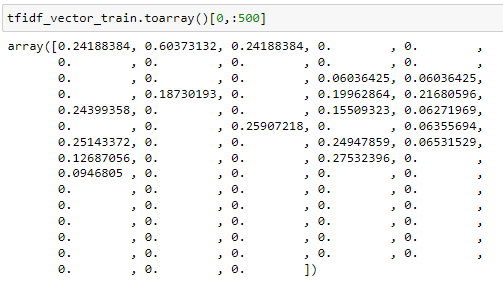

In [79]:
# data_train.loc[:,['language', 'text_token_len']].values
print(len(X_train.toarray()[0,:]))
X_train.toarray()[0,:50]#.sum()

111


array([0.18013857, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.33065433,
       0.66879359, 0.33065433, 0.        , 0.00682467, 0.00810657,
       0.        , 0.01821056, 0.01749703, 0.        , 0.        ,
       0.01014728, 0.        , 0.00428689, 0.00428689, 0.        ,
       0.18183196, 0.03257742, 0.16104507, 0.07221562, 0.28160822])

# Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## estimator
rf_clf = RandomForestClassifier(max_depth = 12, n_jobs = -1, random_state = 123)

## GridSearch
# params = {'max_depth' : [4,6,8,10,12,14,16]}

# grid_rf = GridSearchCV(estimator = rf_clf, param_grid = params, scoring = 'accuracy', n_jobs = -1,\
#                        return_train_score=True, verbose = 2)

## training (timed)
t0 = time.time()

rf_clf.fit(X_train, y_train)
# grid_rf.fit(X_train, y_train)

t1 = time.time()
print("For %d observations, training time = %0.2f seconds" %(X_train.shape[0], (t1-t0) ) )

model_date_time = date_time()
print(model_date_time)

For 33967 observations, training time = 4.36 seconds
_20230807_2330


In [114]:
rf_clf.get_params()
# grid_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

**Grid optimization**

In [110]:
## Best estimators
print("Best estimator:", grid_rf.best_params_)


## Grid evaluation:
to_display = ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
grid_rf_optimization = pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:,to_display]
#print(grid_rf_optimization)


## export grid_cv_results
export = True
time_stamp = model_date_time
if export:
    filename = 'grid_rf_cv_results' + time_stamp + '.csv'
    pd.DataFrame.from_dict(grid_rf.cv_results_).to_csv(filename, header=True, index=False)
    print(filename)

Best estimator: {'max_depth': 16}
grid_rf_cv_results_20230807_2321.csv


In [103]:
## Formating into dataframe: 

for key in params.keys():
    grid_rf_optimization[key] = [val[key] for val in grid_rf_optimization['params']]

#grid_rf_optimization = grid_rf_optimization.drop('params', axis = 1)

grid_rf_optimization

,params,mean_test_score,std_test_score,mean_train_score,std_train_score,max_depth
0,{'max_depth': 4},0.248447,0.003701,0.251612,0.002688,4
1,{'max_depth': 6},0.305355,0.006065,0.321614,0.001304,6
2,{'max_depth': 8},0.359290,0.004554,0.409368,0.001824,8
3,{'max_depth': 10},0.402862,0.003369,0.525613,0.001403,10
4,{'max_depth': 12},0.436188,0.004747,0.694306,0.002314,12
5,{'max_depth': 14},0.457738,0.004538,0.865774,0.002796,14
6,{'max_depth': 16},0.475462,0.005955,0.960947,0.001863,16


**Plot optimization of current model**

Text(0.5, 0.98, 'Optimization: Random Forest on meanRGB')

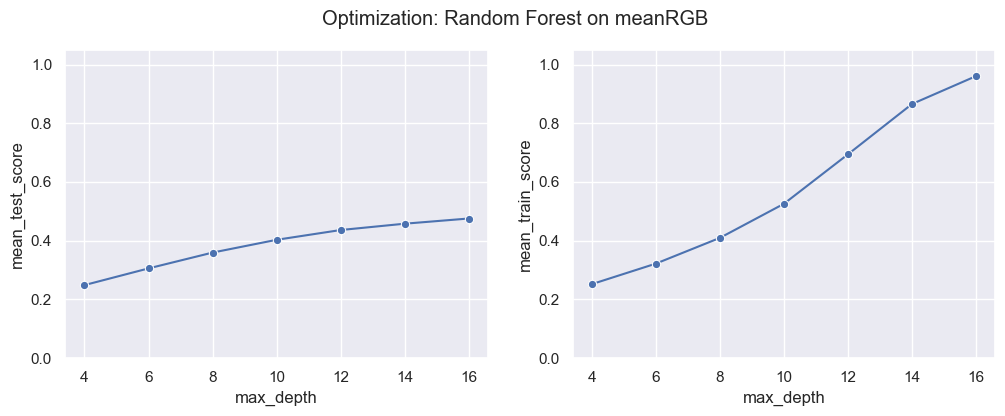

In [104]:
fig, axs = plt.subplots(1,2,figsize = (12,4))
#sns.lineplot(x = 'max_depth', y='mean_test_score', data = grid_rf_optimization, hue = 'criterion', style='max_features', marker = 'o')


sns.lineplot(x = 'max_depth', y='mean_test_score', data = grid_rf_optimization, \
             marker = 'o', ax= axs[0])

# sns.lineplot(x = 'max_depth', y='mean_test_score', data = grid_rf_v0, hue = 'C',\
#              marker = '*', ax= axs[0], ls = ':', palette="crest")


sns.lineplot(x = 'max_depth', y='mean_train_score', data = grid_rf_optimization, \
             marker = 'o', ax= axs[1])

# sns.lineplot(x = 'max_depth', y='mean_train_score', data = grid_rf_v0, hue = 'C',\
#              marker = '*', ax= axs[1], ls = ':', palette="crest")

for ax in axs:
    ax.set_ylim(0,1.05)
#     ax.set_xscale("log")
#     leg = ax.legend()
#     leg_lines = leg.get_lines()
# #     leg_lines[1].set_linestyle(":")
#     leg_lines[2].set_linestyle(":")
#     leg_lines[3].set_linestyle(":")
    
#plt.legend(title='Day of Week')
# plt.legend(labels = ['a', 'F', 'S', 'y'])
fig.suptitle("Optimization: Random Forest on meanRGB")

**Train-Test accuracy**

In [115]:
rf_accuracy_train = rf_clf.score(X_train, y_train)
rf_accuracy_test = rf_clf.score(X_test, y_test)

# rf_accuracy_train = grid_rf.score(X_train, y_train)
# rf_accuracy_test = grid_rf.score(X_test, y_test)

print("Train set accuracy %0.3f" % rf_accuracy_train)
print("Test  set accuracy %0.3f" % rf_accuracy_test)

Train set accuracy 0.661
Test  set accuracy 0.428


**Predictions**

In [116]:
y_pred = rf_clf.predict(X_test)
# y_pred = grid_rf.predict(X_test)

cm = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Predictions'])
#print(cm.shape)
#display(cm)

(27, 25)


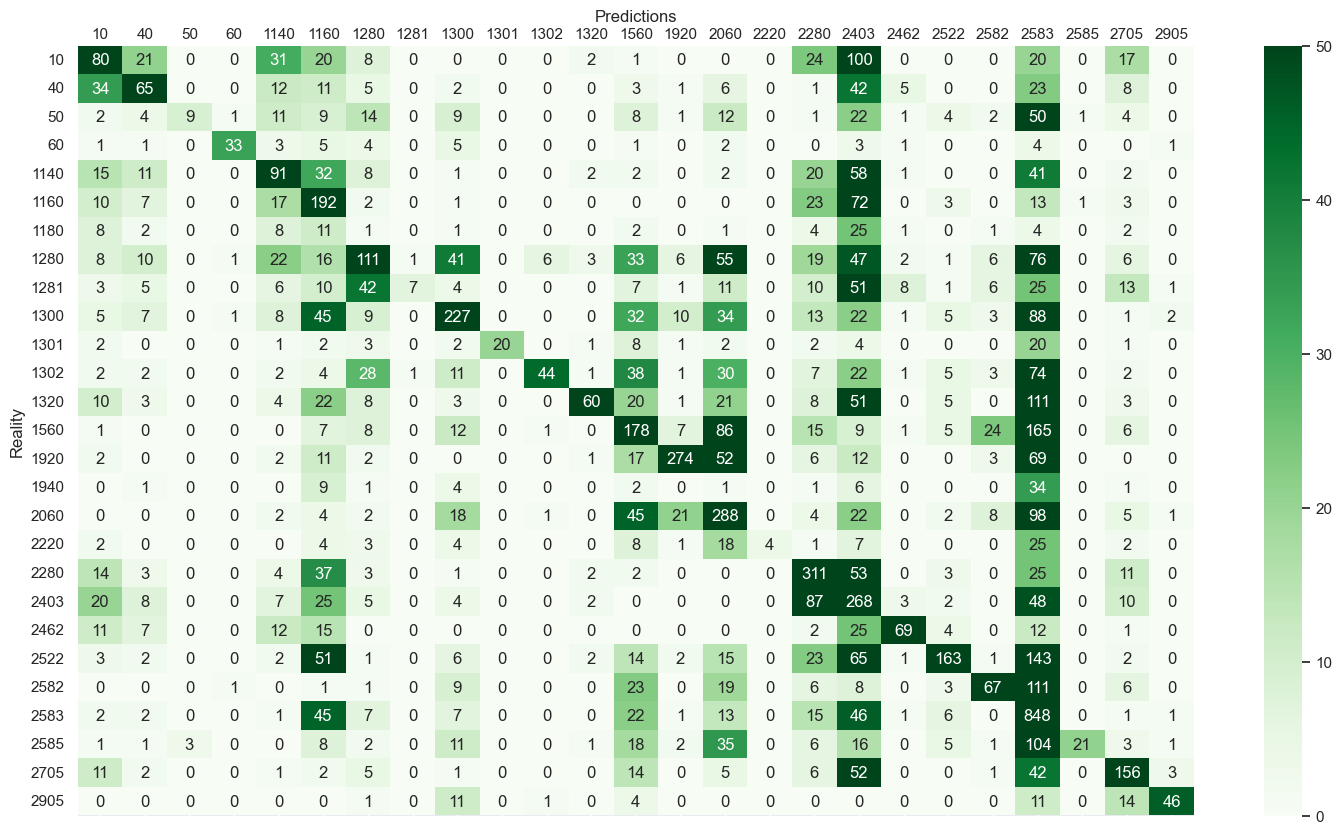

In [117]:
print(cm.shape)

fig, ax = plt.subplots(figsize = (18,10))
sns.heatmap(cm, annot = True, ax=ax, cmap='Greens', fmt ='d', vmin = 0, vmax = 50)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(length = 0)
ax.xaxis.set_label_position('top')

**Save confusion matrix**

In [118]:
export = True

if export:
    filename = 'textModel_rf' + model_date_time + '_confusionMatrix.csv'
    
    with open(filename, 'w') as file:
        cm.to_csv(filename, header = True, index = True)
        print(filename)

textModel_rf_20230807_2330_confusionMatrix.csv


**Classification Report: macro & micro**

In [119]:
from sklearn.metrics import classification_report 

cr = classification_report(y_test, y_pred, output_dict = True)
cr.update({"accuracy": {"precision": None, "recall": None, "f1-score": cr["accuracy"], "support": cr['macro avg']['support']}})

micro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'prdtypecode'}).iloc[:-3,:]
macro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'metrics'}).iloc[-3:,:]

# display(micro_dt)
# display(macro_dt)

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          10       0.32      0.25      0.28       324
          40       0.40      0.30      0.34       218
          50       0.75      0.05      0.10       165
          60       0.89      0.52      0.65        64
        1140       0.37      0.32      0.34       286
        1160       0.32      0.56      0.41       344
        1180       0.00      0.00      0.00        71
        1280       0.39      0.24      0.29       470
        1281       0.78      0.03      0.06       211
        1300       0.57      0.44      0.50       513
        1301       1.00      0.29      0.45        69
        1302       0.83      0.16      0.27       278
        1320       0.78      0.18      0.29       330
        1560       0.35      0.34      0.35       525
        1920       0.83      0.61      0.70       451
        1940       0.00      0.00      0.00        60
        2060       0.41      0.55      0.47       521
        2220       1.00    

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Top Classified Categories**

In [121]:
micro_rf.sort_values(by = 'f1-score', ascending=False).head(5)

,prdtypecode,precision,recall,f1-score,support
14,1920,0.830303,0.607539,0.701665,451.0
3,60,0.891892,0.515625,0.653465,64.0
26,2905,0.821429,0.522727,0.638889,88.0
18,2280,0.505691,0.663113,0.573801,469.0
20,2462,0.718750,0.436709,0.543307,158.0


**Save Classification Report**

In [122]:
export = True

if export:
    filename = 'textModel_rf' + model_date_time + '_classificationReport.txt'
    
    with open(filename, 'w') as file:
        file.write(classification_report(y_test, y_pred))
        print(filename)

textModel_rf_20230807_2330_classificationReport.txt


C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Save trained model**

In [124]:
export = True

if export:
    filename = 'textModel_rf_trainedModel' + model_date_time + '.txt'
    print(filename)
    
    with open(filename, 'w') as file:
        file.write(json.dumps(rf_clf.get_params()))

textModel_rf_trainedModel_20230807_2330.txt


**Load pre-Trained model**

In [89]:
export = False

if export:
    filename = 'textModel_rf_trainedModel' + learnCurve_date_time + '.txt'
    
    with open(filename, 'r') as file:
        reloadedModel = json.load(file)
        
    reloadedModel

# SVM.SVC model


In [172]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

## estimator
svc_clf = svm.SVC(C = 10, kernel = 'rbf') # kernel = 'poly', gamma = 0.01

## GridSearch
# params = {'gamma' : [1e-11,1e-10,1e-9,1e-8,1e-7,1e-6]}#,
# #          'C' : [1e3,1e4,1e5,1e6] }

# grid_svc = GridSearchCV(estimator = svc_clf, param_grid = params, scoring = 'accuracy', n_jobs = -1, cv = 3,\
#                           return_train_score=True, verbose = 3)

## training (timed)
t0 = time.time()

svc_clf.fit(X_train, y_train)
# grid_svc.fit(X_train, y_train)

t1 = time.time()
print("For %d observations, training time = %0.2f seconds" %(X_train.shape[0], (t1-t0) ) )

model_date_time = date_time()
print(model_date_time)

For 33967 observations, training time = 157.04 seconds
_20230808_0001


**Train-Test accuracy**

In [173]:
t0 = time.time()

svc_accuracy_train = svc_clf.score(X_train, y_train)
svc_accuracy_test = svc_clf.score(X_test, y_test)

# svc_accuracy_train = grid_svc.score(X_train, y_train)
# svc_accuracy_test = grid_svc.score(X_test, y_test)

print("Train set accuracy %0.3f" % svc_accuracy_train)
print("Test  set accuracy %0.3f" % svc_accuracy_test)

t1 = time.time()
print("Training and test set accuracy measured in %0.2f seconds" %((t1-t0) ) )

Train set accuracy 0.473
Test  set accuracy 0.432
Training and test set accuracy measured in 257.20 seconds


**Predictions**

In [174]:
t0 = time.time()

y_pred = svc_clf.predict(X_test)
# y_pred = grid_rf_px.predict(X_test)

t1 = time.time()
print("Predictions done in %0.2f seconds" %((t1-t0) ) )

cm = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Predictions'])
#print(cm.shape)
#display(cm)

Predictions done in 53.46 seconds


(27, 26)


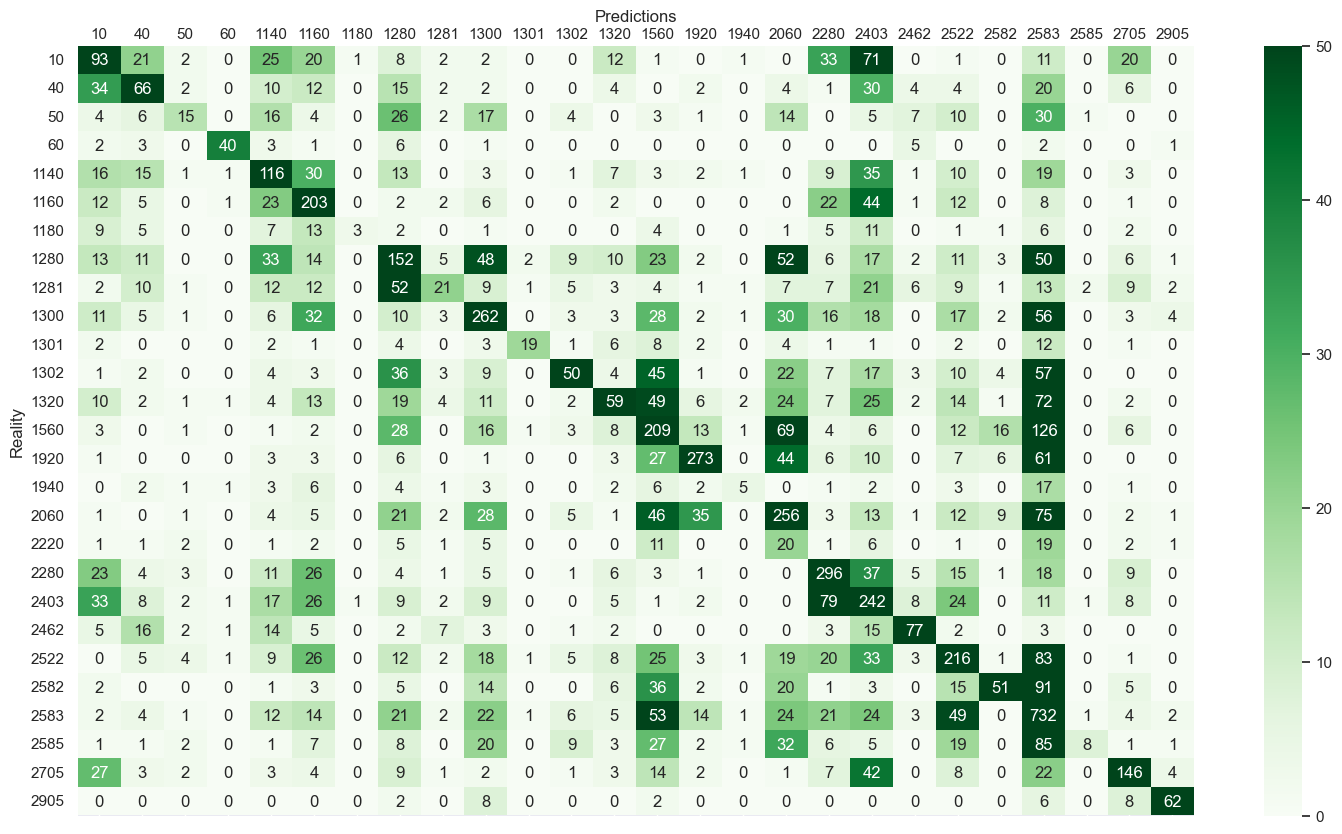

In [175]:
print(cm.shape)

fig, ax = plt.subplots(figsize = (18,10))
sns.heatmap(cm, annot = True, ax=ax, cmap='Greens', fmt ='d', vmin = 0, vmax = 50)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(length = 0)
ax.xaxis.set_label_position('top')

**Save confusion matrix**

In [179]:
export = True

if export:
    filename = 'textModel_svc' + model_date_time + '_confusionMatrix.csv'
    
    with open(filename, 'w') as file:
        cm.to_csv(filename, header = True, index = True)
        print(filename)

textModel_svc_20230808_0001_confusionMatrix.csv


**Classification Report: macro & micro**

In [176]:
from sklearn.metrics import classification_report 

cr = classification_report(y_test, y_pred, output_dict = True)
cr.update({"accuracy": {"precision": None, "recall": None, "f1-score": cr["accuracy"], "support": cr['macro avg']['support']}})

micro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'prdtypecode'}).iloc[:-3,:]
macro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'metrics'}).iloc[-3:,:]

# display(micro_dt)
# display(macro_dt)

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [177]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          10       0.30      0.29      0.29       324
          40       0.34      0.30      0.32       218
          50       0.34      0.09      0.14       165
          60       0.85      0.62      0.72        64
        1140       0.34      0.41      0.37       286
        1160       0.42      0.59      0.49       344
        1180       0.60      0.04      0.08        71
        1280       0.32      0.32      0.32       470
        1281       0.33      0.10      0.15       211
        1300       0.50      0.51      0.50       513
        1301       0.76      0.28      0.40        69
        1302       0.47      0.18      0.26       278
        1320       0.36      0.18      0.24       330
        1560       0.33      0.40      0.36       525
        1920       0.74      0.61      0.67       451
        1940       0.33      0.08      0.13        60
        2060       0.40      0.49      0.44       521
        2220       0.00    

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Top Classified Categories**

In [178]:
micro_rf.sort_values(by = 'f1-score', ascending=False).head(5)

,prdtypecode,precision,recall,f1-score,support
26,2905,0.784810,0.704545,0.742515,88.0
3,60,0.851064,0.625000,0.720721,64.0
14,1920,0.741848,0.605322,0.666667,451.0
18,2280,0.526690,0.631130,0.574200,469.0
20,2462,0.601562,0.487342,0.538462,158.0


**Save Classification Report**

In [180]:
export = True

if export:
    filename = 'textModel_svc' + model_date_time + '_classificationReport.txt'
    
    with open(filename, 'w') as file:
        file.write(classification_report(y_test, y_pred))
        print(filename)

textModel_svc_20230808_0001_classificationReport.txt


C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Save model hyperparameters**

In [181]:
export = True

if export:
    filename = 'textModel_svc_trainedModel' + model_date_time + '.txt'
    print(filename)
    
    with open(filename, 'w') as file:
        file.write(json.dumps(rf_clf.get_params()))

textModel_svc_trainedModel_20230808_0001.txt


**Load model hyperparameters**

In [185]:
export = True

if export:
    filename = 'textModel_svc_trainedModel_20230808_0001.txt'
    
    with open(filename, 'r') as file:
        reloadedModel = json.load(file)
        
    print(reloadedModel)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


# Simple Neural Network
- [x] Normalize features [0,1] range

- [ ] LAbelEncoder target to go from 0 to 26
- [ ] One hot encode target variable: vector --> matrix

- [ ] NN model
- [ ] NN compiler
- [ ] 

**Label encoder**

In [125]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()

y_train_encoded = target_encoder.fit_transform(y_train)
y_test_encoded = target_encoder.transform(y_test)

target_encoder.classes_
# target_encoder.inverse_transform(y_test)
# target_encoder.inverse_transform([18])

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905], dtype=int64)

**On-Hot-Encoding of target variables**

In [126]:
from tensorflow.keras.utils import to_categorical

yy_train = to_categorical(y_train_encoded, dtype = 'int') 
yy_test = to_categorical(y_test_encoded, dtype = 'int')   

yy_train.shape

(33967, 27)

In [127]:
i = 20
print("Exmaple %d: Class '%d' is encoded as vector:"%(i, y_train.iloc[i]), y_train_encoded[i], yy_train[i,:])

Exmaple 20: Class '2060' is encoded as vector: 16 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


27

**Define model : NN layers**

In [159]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

## data dimensions
Nb_features = X_train.shape[1]
Nb_classes = yy_train.shape[1]


## instantiate layers

inputs = Input(shape = Nb_features, name = "Input")

dense1 = Dense(units = 1000, activation = "tanh", \
               kernel_initializer ='normal', name = "Dense_1")

dense2 = Dense(units = Nb_classes, activation = "softmax", \
               kernel_initializer ='normal', name = "Dense_2")


## link layers & model

x = dense1(inputs)
outputs = dense2(x)

NN_clf = Model(inputs = inputs, outputs = outputs)

In [160]:
## to visualize a schema of the model

from tensorflow.keras.utils import plot_model
plot_model(NN_clf)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**Define training process**

In [161]:
NN_clf.compile(loss = 'categorical_crossentropy',  
              optimizer = 'adam',                 
              metrics = ['accuracy'])             


**Train Model**

In [162]:
t0 = time.time()

training_history = NN_clf.fit(X_train.toarray(), yy_train,          
                             epochs = 200,               
                             batch_size = 200,          
                             validation_split = 0.2)

t1 = time.time()
print("For %d observations, training time = %0.2f seconds" %(X_train.shape[0], (t1-t0) ) )

model_date_time = date_time()
print(model_date_time)

Epoch 1/200
136/136 [==============================] - 1s 5ms/step - loss: 2.8597 - accuracy: 0.1687 - val_loss: 2.6348 - val_accuracy: 0.2231
Epoch 2/200
136/136 [==============================] - 0s 4ms/step - loss: 2.5243 - accuracy: 0.2710 - val_loss: 2.4465 - val_accuracy: 0.3000
Epoch 3/200
136/136 [==============================] - 1s 4ms/step - loss: 2.3899 - accuracy: 0.3198 - val_loss: 2.3587 - val_accuracy: 0.3298
Epoch 4/200
136/136 [==============================] - 0s 4ms/step - loss: 2.3227 - accuracy: 0.3434 - val_loss: 2.3064 - val_accuracy: 0.3508
Epoch 5/200
136/136 [==============================] - 0s 4ms/step - loss: 2.2796 - accuracy: 0.3529 - val_loss: 2.2874 - val_accuracy: 0.3634
Epoch 6/200
136/136 [==============================] - 0s 4ms/step - loss: 2.2551 - accuracy: 0.3629 - val_loss: 2.2546 - val_accuracy: 0.3616
Epoch 7/200
136/136 [==============================] - 1s 4ms/step - loss: 2.2339 - accuracy: 0.3684 - val_loss: 2.2405 - val_accuracy: 0.3668

Epoch 58/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1411 - accuracy: 0.3894 - val_loss: 2.1792 - val_accuracy: 0.3945
Epoch 59/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1428 - accuracy: 0.3905 - val_loss: 2.1857 - val_accuracy: 0.3817
Epoch 60/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1440 - accuracy: 0.3904 - val_loss: 2.1834 - val_accuracy: 0.3981
Epoch 61/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1411 - accuracy: 0.3910 - val_loss: 2.1858 - val_accuracy: 0.3903
Epoch 62/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1423 - accuracy: 0.3910 - val_loss: 2.1863 - val_accuracy: 0.3881
Epoch 63/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1408 - accuracy: 0.3911 - val_loss: 2.1813 - val_accuracy: 0.3956
Epoch 64/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1407 - accuracy: 0.3923 - val_loss: 2.1888 - val_accuracy:

Epoch 115/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1194 - accuracy: 0.3966 - val_loss: 2.1897 - val_accuracy: 0.3850
Epoch 116/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1191 - accuracy: 0.3970 - val_loss: 2.1683 - val_accuracy: 0.4006
Epoch 117/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1200 - accuracy: 0.3953 - val_loss: 2.1627 - val_accuracy: 0.4001
Epoch 118/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1177 - accuracy: 0.3984 - val_loss: 2.1616 - val_accuracy: 0.3945
Epoch 119/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1177 - accuracy: 0.3985 - val_loss: 2.1629 - val_accuracy: 0.4045
Epoch 120/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1157 - accuracy: 0.3988 - val_loss: 2.1646 - val_accuracy: 0.4020
Epoch 121/200
136/136 [==============================] - 1s 4ms/step - loss: 2.1148 - accuracy: 0.3990 - val_loss: 2.1657 - val_ac

**Score Evolution during training**

In [163]:
x_epochs = np.arange(1,201,1)

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

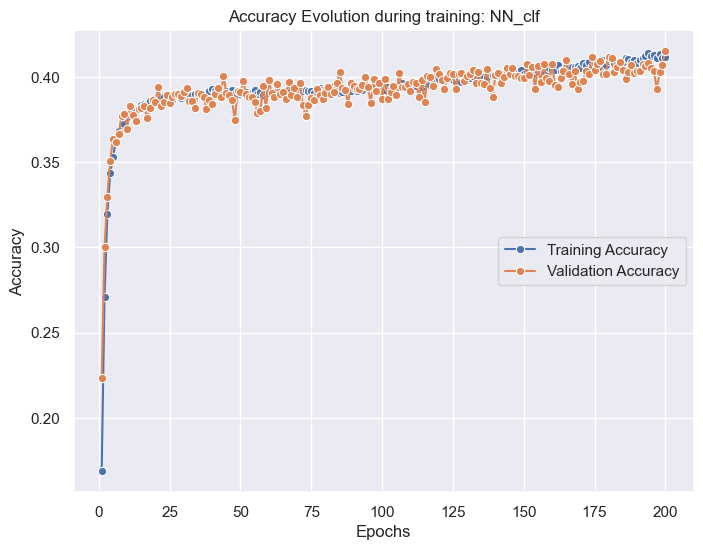

In [164]:
plt.figure(figsize=(8,6))

sns.lineplot(x = x_epochs, y = train_acc, marker = 'o', label = 'Training Accuracy')
sns.lineplot(x = x_epochs, y = val_acc, marker = 'o', label = 'Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution during training: NN_clf')
plt.legend(loc='right')

**Train-Test accuracy**

In [165]:
loss_train, NN_accuracy_train = NN_clf.evaluate(X_train.toarray(), yy_train)
loss_test, NN_accuracy_test = NN_clf.evaluate(X_test.toarray(), yy_test)

# svc_accuracy_train = grid_svc.score(X_train, y_train)
# svc_accuracy_test = grid_svc.score(X_test, y_test)

print("Train set accuracy = %0.3f and loss function = %0.2f" %(NN_accuracy_train, loss_train) )
print("Test  set accuracy = %0.3f and loss function = %0.2f" %(NN_accuracy_test, loss_test))

266/266 [==============================] - 1s 2ms/step - loss: 2.1474 - accuracy: 0.4005
Train set accuracy = 0.419 and loss function = 2.06
Test  set accuracy = 0.400 and loss function = 2.15


**Predictions**

In [166]:
y_pred_vectors = NN_clf.predict(X_test.toarray())

## reverse One-hot-encoding
y_pred_class = y_pred_vectors.argmax(axis = 1)
yy_test_class = yy_test.argmax(axis = 1)

## reverse label encoder
y_pred = target_encoder.inverse_transform(y_pred_class)
yy_test_prdCode = target_encoder.inverse_transform(yy_test_class)   # should be equal to y_test



266/266 [==============================] - 0s 1ms/step


In [167]:
print(yy_test_prdCode)
print(y_test.values)

[1560 2403 2060 ... 2280 2522 1320]
[1560 2403 2060 ... 2280 2522 1320]


**Confussion Matrix**

In [168]:
cm = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Predictions'])
#print(cm.shape)
#display(cm)

(27, 27)


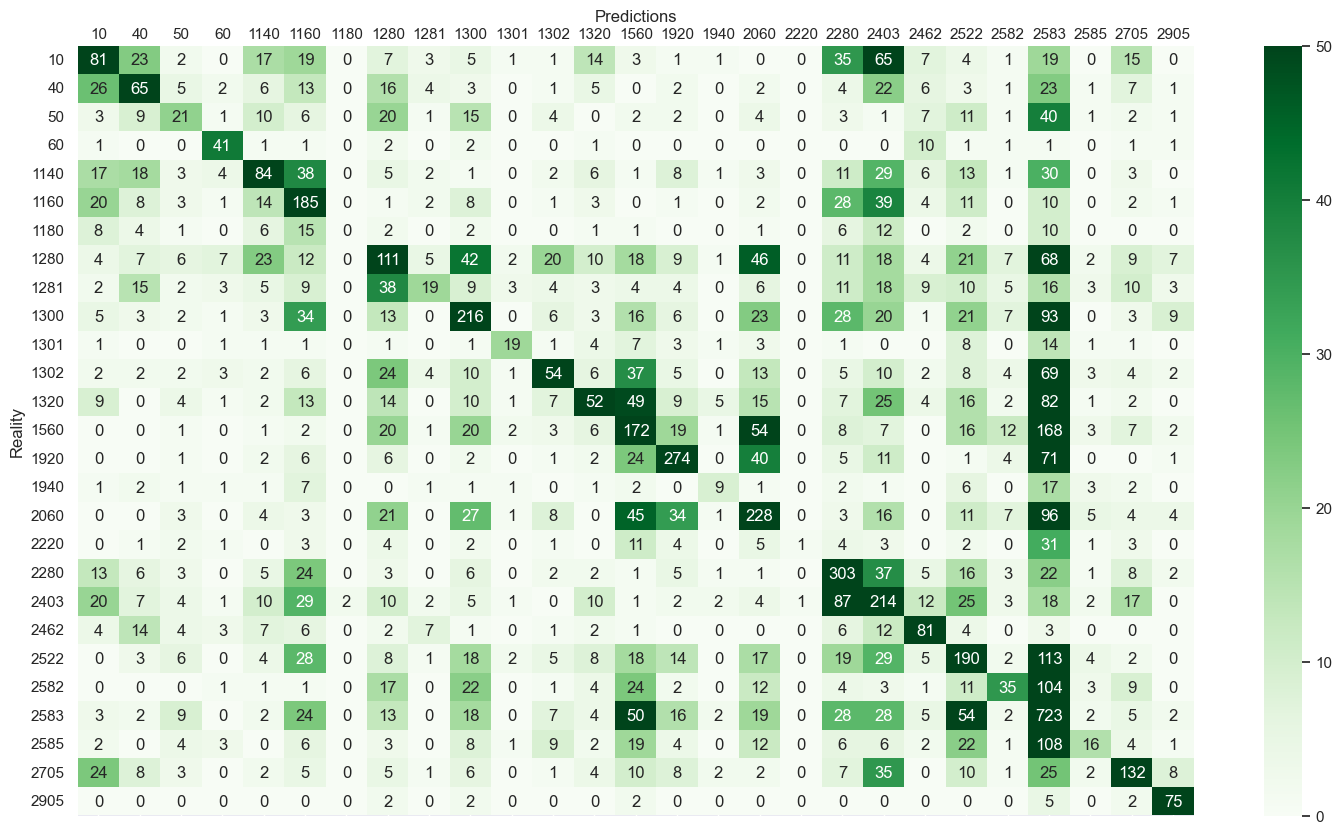

In [169]:
print(cm.shape)

fig, ax = plt.subplots(figsize = (18,10))
sns.heatmap(cm, annot = True, ax=ax, cmap='Greens', fmt ='d', vmin = 0, vmax = 50)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(length = 0)
ax.xaxis.set_label_position('top')

**Save confusion matrix**

In [60]:
export = False

if export:
    filename = 'textModel_svc' + model_date_time + '_confusionMatrix.csv'
    
    with open(filename, 'w') as file:
        cm.to_csv(filename, header = True, index = True)
        print(filename)

**Classification Report: macro & micro**

In [277]:
from sklearn.metrics import classification_report 

cr = classification_report(y_test, y_pred, output_dict = True)
cr.update({"accuracy": {"precision": None, "recall": None, "f1-score": cr["accuracy"], "support": cr['macro avg']['support']}})

micro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'prdtypecode'}).iloc[:-3,:]
macro_rf = pd.DataFrame(cr).transpose().reset_index().rename(columns={'index': 'metrics'}).iloc[-3:,:]

# display(micro_dt)
# display(macro_dt)

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [278]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          10       1.00      0.01      0.02        79
          40       0.00      0.00      0.00        54
          50       0.00      0.00      0.00        40
          60       0.00      0.00      0.00        22
        1140       0.00      0.00      0.00        55
        1160       0.00      0.00      0.00        75
        1180       0.00      0.00      0.00        14
        1280       0.00      0.00      0.00        95
        1281       0.00      0.00      0.00        39
        1300       0.00      0.00      0.00       100
        1301       0.00      0.00      0.00        20
        1302       0.00      0.00      0.00        47
        1320       0.00      0.00      0.00        65
        1560       0.00      0.00      0.00       117
        1920       0.00      0.00      0.00        82
        1940       0.00      0.00      0.00        15
        2060       0.00      0.00      0.00       101
        2220       0.00    

C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19rod\anaconda3\envs\rakuten_env2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Top Classified Categories**

In [279]:
micro_rf.sort_values(by = 'f1-score', ascending=False).head(5)

,prdtypecode,precision,recall,f1-score,support
23,2583,0.106848,1.000000,0.193067,181.0
0,10,1.000000,0.012658,0.025000,79.0
14,1920,0.000000,0.000000,0.000000,82.0
25,2705,0.000000,0.000000,0.000000,63.0
24,2585,0.000000,0.000000,0.000000,54.0


**Save Classification Report**

In [280]:
export = False

if export:
    filename = 'textModel_svc' + model_date_time + '_classificationReport.txt'
    
    with open(filename, 'w') as file:
        file.write(classification_report(y_test, y_pred))
        print(filename)

**Save trained model**

In [284]:
export = False

if export:
    filename = 'textModel_NN_trainedModel' + model_date_time + '.txt'
    
    with open(filename, 'w') as file:
        file.write(json.dumps(NN_clf.get_params()))
        print(filename)


**Load pre-Trained model**

In [283]:
reload = False

if reload:
    filename = 'textModel_NN_trainedModel' + learnCurve_date_time + '.txt'
    
    with open(filename, 'r') as file:
        reloadedModel = json.load(file)
        
    reloadedModel

**Classification report**

# Exporting preprocessed text

In [92]:
write = False
if write:
    filename = 'df_text_preprocessed' + '.csv'
    df.to_csv(filename, header=True, index=False)

In [ ]:
write_pickle = False

t0 = time.time()
if write_pickle:
    filename = 'df_text_preprocessed' + '.pkl'
    df_vectorized_images.to_pickle(filename) #, header=True, index=False

print("Total time = %0.2f seconds" %(time.time()-t0) )    
write_pickle = False

### Most Common words per category 
[ ] how to include this information ? in the dataframe or a model ?

### Feature engineering: Statistical indicators per category
These are the mean, min, max, etc of text_token_len per category.

[ ] How to include them in the dataframe ???

### Save trained model ready to use

In [ ]:
save = False
reload = False

#saved_model = 'Model_svm_optimmized' + model_date_time + '.joblib'
saved_model = 'Model_svm_optimmized' + '_20230803_0742' + '.joblib'

from joblib import dump, load

if save:
    dump(svc_clf, saved_model) #

if reload:
#     my_model=load(saved_model)
    svc_clf=load(saved_model)
    print("reloaded model: ", saved_model)

# Dump non used functions

**CountVectorize -> TFIDF_transform**

In [191]:
# def token_to_text(token_list):
#     '''
#     Concatenate all token of an item to for a sentence (lemmatized already)
#     '''
#     text = '' 
#     for token in token_list:
#         text = text + token + ' '
#     return text

# token_to_text(df.loc[0,'lemma_tokens'])

In [192]:
# data_train['lemma_text'] = data_train['lemma_tokens'].apply(token_to_text)
# data_test['lemma_text'] = data_test['lemma_tokens'].apply(token_to_text)

In [200]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = do_nothing, lowercase=False) #max_features=5000, 

#vectorText_train = vectorizer.fit_transform(df['lemma_tokens'].apply(token_to_text))
lemma_vector_train = vectorizer.fit_transform(data_train['lemma_tokens'])
lemma_vector_test = vectorizer.transform(data_test['lemma_tokens'])


In [204]:
## print info about the vectorizer trained
# vectorizer.get_feature_names_out()
print(len(vectorizer.vocabulary_))
#vectorizer.vocabulary_.get('charles')

## print info about the vectors obtained
# lemma_vector_train.toarray().shape
lemma_vector_train.toarray()[1,:100]

42648


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [175]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer_TFIDF = TfidfTransformer(smooth_idf=True)

tfidf_train = transformer_TFIDF.fit_transform(lemma_vector_train)

In [176]:
tfidf_train.toarray()[1,:100]

array([0.11640882, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06369834, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.13745048,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

**For Scaling token_len**

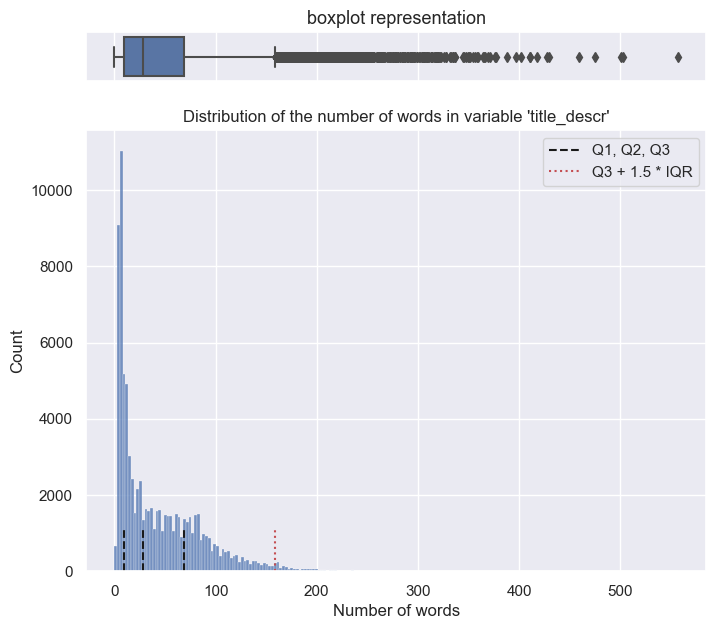

In [307]:
# quantile values
q1, q2, q3 = df['text_token_len'].quantile(q=[0.25,0.5,0.75])
iqr = q3-q1

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
fsize = 14



fig, (ax_box, ax_hist) = plt.subplots(2, figsize = (8,7), sharex=True, gridspec_kw={"height_ratios": (.1, .9)})
plt.title("Distribution of the number of words in variable 'title_descr'")#, fontsize = fsize)

## Box plot
sns.boxplot(x = df.text_token_len, ax = ax_box)
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title('boxplot representation', fontsize = 13)
## hist plot

sns.histplot(x = df.text_token_len, ax = ax_hist)#, kde = True

# add quantiles and extreme values markers
ax_hist.axvline(x=q1, ymin= 0, ymax = 0.1, c='k', ls = '--', label='Q1, Q2, Q3')
ax_hist.axvline(x=q2, ymin= 0, ymax = 0.1, c='k', ls = '--')
ax_hist.axvline(x=q3, ymin= 0, ymax = 0.1, c='k', ls = '--')
ax_hist.axvline(x=q3+1.5*iqr, ymin= 0, ymax = 0.1, c='r', ls = ':', label='Q3 + 1.5 * IQR')
ax_hist.legend()

plt.xlabel('Number of words')
#plt.xlim([0,500])
#plt.ylim([0,10])
plt.show()